# Algorithmics Trading Using LSTM Regression Long Strategy

## Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
from datetime import date

import yfinance as yf
import pyfolio as pf

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

/Users/alfred/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [116]:
data = yf.download('MSFT')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400
...,...,...,...,...,...,...
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700
2022-06-08,271.709991,273.000000,269.609985,270.410004,270.410004,17372300


<AxesSubplot:xlabel='Date'>

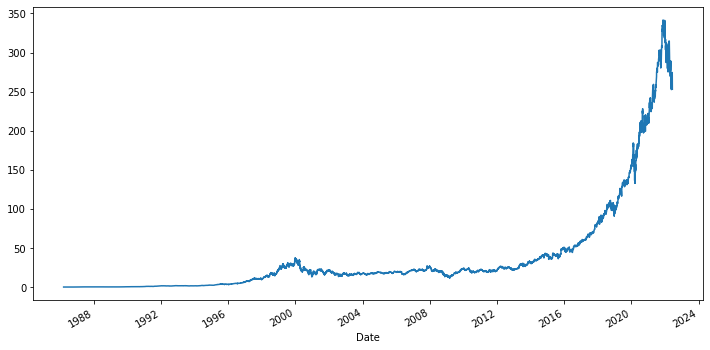

In [117]:
data['Adj Close'].plot()

## Compute Returns and Define Target

In [118]:
data['return'] = data['Adj Close'].pct_change()
#data['target'] = np.where(data['return'].shift(-1) > 0, 1, 0)
data['target'] = data['return'].shift(-1)

p=21*8
data['min'] = data['Low'].rolling(p).min()
data['max'] = data['High'].rolling(p).max()
data.dropna(inplace=True)
data

,Open,High,Low,Close,Adj Close,Volume,return,target,min,max
Date,,,,,,,,,,
1986-11-07,0.154514,0.155382,0.151042,0.153646,0.096575,44323200,-0.005618,-0.039552,0.088542,0.157986
1986-11-10,0.153646,0.153646,0.146701,0.147569,0.092755,28684800,-0.039552,0.005889,0.089410,0.157986
1986-11-11,0.148438,0.150174,0.148438,0.148438,0.093301,11894400,0.005889,0.000000,0.089410,0.157986
1986-11-12,0.148438,0.151910,0.146701,0.148438,0.093301,34156800,0.000000,-0.014625,0.089410,0.157986
1986-11-13,0.148438,0.149306,0.145833,0.146267,0.091937,30211200,-0.014625,0.008902,0.089410,0.157986
...,...,...,...,...,...,...,...,...,...,...
2022-06-03,270.309998,273.450012,268.410004,270.019989,270.019989,28048000,-0.016607,-0.004703,246.440002,349.670013
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300,-0.004703,0.013953,246.440002,349.670013
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700,0.013953,-0.007670,246.440002,349.670013


## Scale the Data by Rolling Min-Max Method

In [119]:
data2 = data.copy()
data2['Open'] = (data2['Open']-data2['min'])/(data2['max']-data2['min'])
data2['High'] = (data2['High']-data2['min'])/(data2['max']-data2['min'])
data2['Low'] = (data2['Low']-data2['min'])/(data2['max']-data2['min'])
data2['Close'] = (data2['Close']-data2['min'])/(data2['max']-data2['min'])
data2['Adj Close'] = (data2['Adj Close']-data2['min'])/(data2['max']-data2['min'])
data2.dropna(inplace=True)
data2

,Open,High,Low,Close,Adj Close,Volume,return,target,min,max
Date,,,,,,,,,,
1986-11-07,0.950003,0.962502,0.900006,0.937504,0.115675,44323200,-0.005618,-0.039552,0.088542,0.157986
1986-11-10,0.936713,0.936713,0.835438,0.848096,0.048782,28684800,-0.039552,0.005889,0.089410,0.157986
1986-11-11,0.860768,0.886083,0.860768,0.860768,0.056746,11894400,0.005889,0.000000,0.089410,0.157986
1986-11-12,0.860768,0.911398,0.835438,0.860768,0.056746,34156800,0.000000,-0.014625,0.089410,0.157986
1986-11-13,0.860768,0.873425,0.822781,0.829109,0.036848,30211200,-0.014625,0.008902,0.089410,0.157986
...,...,...,...,...,...,...,...,...,...,...
2022-06-03,0.231231,0.261649,0.212826,0.228422,0.228422,28048000,-0.016607,-0.004703,246.440002,349.670013
2022-06-06,0.248184,0.268720,0.201298,0.216119,0.216119,22400300,-0.004703,0.013953,246.440002,349.670013
2022-06-07,0.195680,0.258549,0.188899,0.252446,0.252446,22860700,0.013953,-0.007670,246.440002,349.670013


## Create X-y Pair for LSTM

In [120]:
def sliding_window(data, timesteps):
    x = []
    y = []

    for i in range(len(data)-timesteps):
        _x = data.iloc[i:(i+timesteps)][['Open','High','Low','Adj Close']]
        _y = data.iloc[i+timesteps-1]['target']
    
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [121]:
timesteps = 5
X,y = sliding_window(data2, timesteps)

In [122]:
X.shape,y.shape

((8964, 5, 4), (8964,))

## Train-Test Data Split

In [123]:
# Total dataset length
dataset_length = X.shape[0]

# Training dataset length
split = int(dataset_length * 0.7)
split

6274

In [124]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6274, 5, 4) (2690, 5, 4)
(6274,) (2690,)


## Define the Model

In [125]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

feature = X_train.shape[2]
hidden_size = 5

model = Sequential()
model.add(LSTM(hidden_size,input_shape=(timesteps,feature)))
model.add(Dense(1, activation='linear'))

In [45]:
#Stacked LSTM Moddel

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM,Dense

# feature = X_train.shape[2]
# hidden_size = 5

# model = Sequential()
# model.add(LSTM(hidden_size,return_sequences=True,input_shape=(timesteps,feature)))
# model.add(LSTM(hidden_size,return_sequences=True))
# model.add(LSTM(hidden_size))
# model.add(Dense(1, activation='linear'))

In [ ]:
# Bidirectional LSTM model 

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM,Dense,Bidirectional

# feature = X_train.shape[2]
# hidden_size = 5

# model = Sequential()
# model.add(Bidirectional(LSTM(hidden_size,input_shape=(timesteps,feature))))
# model.add(Dense(1, activation='linear'))

In [ ]:
# Bidirectional Stacked LSTM model 

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM,Dense,Bidirectional

# feature = X_train.shape[2]
# hidden_size = 5

# model = Sequential()
# model.add(Bidirectional(LSTM(hidden_size,return_sequences=True,input_shape=(timesteps,feature))))
# model.add(Bidirectional(LSTM(hidden_size)))
# model.add(Dense(1, activation='linear'))

In [126]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

## Train the Model

In [127]:
history = model.fit(X_train, y_train, epochs=200,batch_size=32)

Epoch 1/200
197/197 [==============================] - 2s 2ms/step - loss: 0.0567 - accuracy: 0.0247
Epoch 2/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.0247
Epoch 3/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0464 - accuracy: 0.0247
Epoch 4/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0419 - accuracy: 0.0247
Epoch 5/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.0247
Epoch 6/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.0247
Epoch 7/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.0247
Epoch 8/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0272 - accuracy: 0.0247
Epoch 9/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.0247
Epoch 10/200
197/197 [==============================] - 0s 2ms/step - loss: 0.0217 - accura

## Evaluate the Model

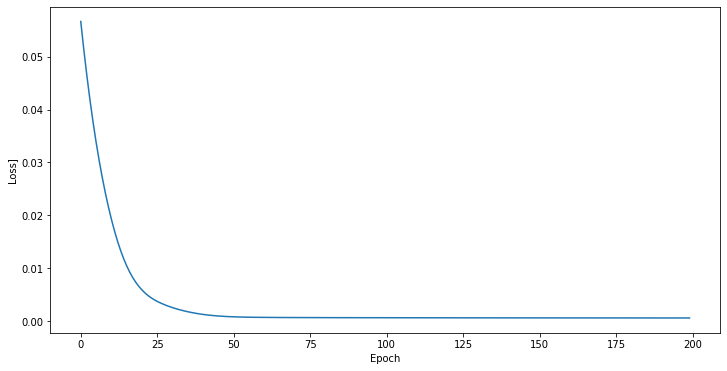

In [128]:
loss = history.history['loss']
epoch = range(len(loss))

import matplotlib.pyplot as plt

plt.plot(epoch,loss)
plt.xlabel('Epoch')
plt.ylabel('Loss]')
plt.show()

In [129]:
loss, acc = model.evaluate(X_test,y_test)
print(f"Accuracy of the model = {np.round(acc*100,2)}%")

85/85 [==============================] - 0s 923us/step - loss: 3.1677e-04 - accuracy: 0.0089
Accuracy of the model = 0.89%


## Trade Analytics

In [130]:
y_pred = np.where(model.predict(X_test)>0,1,0)

In [131]:
offset = len(data)-len(X)
data.drop(data.index[:offset], axis=0, inplace=True)
data['pred_returns']=model.predict(X)
data['signal'] = np.where(model.predict(X)>0,1,0)
data

,Open,High,Low,Close,Adj Close,Volume,return,target,min,max,pred_returns,signal
Date,,,,,,,,,,,,
1986-11-14,0.146267,0.147569,0.143229,0.147569,0.092755,18720000,0.008902,0.005889,0.089410,0.157986,0.003978,1
1986-11-17,0.147569,0.150174,0.145833,0.148438,0.093301,24307200,0.005889,-0.052635,0.089410,0.157986,0.003483,1
1986-11-18,0.148438,0.149306,0.140625,0.140625,0.088391,59673600,-0.052635,0.037035,0.089410,0.157986,0.001120,1
1986-11-19,0.140625,0.146701,0.140625,0.145833,0.091664,48729600,0.037035,0.077383,0.089410,0.157986,0.002519,1
1986-11-20,0.145833,0.157118,0.145833,0.157118,0.098757,98179200,0.077383,0.033147,0.090278,0.157986,-0.001175,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03,270.309998,273.450012,268.410004,270.019989,270.019989,28048000,-0.016607,-0.004703,246.440002,349.670013,0.021708,1
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300,-0.004703,0.013953,246.440002,349.670013,0.023227,1
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700,0.013953,-0.007670,246.440002,349.670013,0.025396,1


In [136]:
data['strategy_returns'] = data['return'].shift(-1) * data['signal']
data

,Open,High,Low,Close,Adj Close,Volume,return,target,min,max,pred_returns,signal,entry,strategy_returns
Date,,,,,,,,,,,,,,
1986-11-14,0.146267,0.147569,0.143229,0.147569,0.092755,18720000,0.008902,0.005889,0.089410,0.157986,0.003978,1,NaN,0.005889
1986-11-17,0.147569,0.150174,0.145833,0.148438,0.093301,24307200,0.005889,-0.052635,0.089410,0.157986,0.003483,1,0.0,-0.052635
1986-11-18,0.148438,0.149306,0.140625,0.140625,0.088391,59673600,-0.052635,0.037035,0.089410,0.157986,0.001120,1,0.0,0.037035
1986-11-19,0.140625,0.146701,0.140625,0.145833,0.091664,48729600,0.037035,0.077383,0.089410,0.157986,0.002519,1,0.0,0.077383
1986-11-20,0.145833,0.157118,0.145833,0.157118,0.098757,98179200,0.077383,0.033147,0.090278,0.157986,-0.001175,0,-1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03,270.309998,273.450012,268.410004,270.019989,270.019989,28048000,-0.016607,-0.004703,246.440002,349.670013,0.021708,1,0.0,-0.004703
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300,-0.004703,0.013953,246.440002,349.670013,0.023227,1,0.0,0.013953
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700,0.013953,-0.007670,246.440002,349.670013,0.025396,1,0.0,-0.007670


In [137]:
data['entry'] = data['signal'].diff()
data

,Open,High,Low,Close,Adj Close,Volume,return,target,min,max,pred_returns,signal,entry,strategy_returns
Date,,,,,,,,,,,,,,
1986-11-14,0.146267,0.147569,0.143229,0.147569,0.092755,18720000,0.008902,0.005889,0.089410,0.157986,0.003978,1,NaN,0.005889
1986-11-17,0.147569,0.150174,0.145833,0.148438,0.093301,24307200,0.005889,-0.052635,0.089410,0.157986,0.003483,1,0.0,-0.052635
1986-11-18,0.148438,0.149306,0.140625,0.140625,0.088391,59673600,-0.052635,0.037035,0.089410,0.157986,0.001120,1,0.0,0.037035
1986-11-19,0.140625,0.146701,0.140625,0.145833,0.091664,48729600,0.037035,0.077383,0.089410,0.157986,0.002519,1,0.0,0.077383
1986-11-20,0.145833,0.157118,0.145833,0.157118,0.098757,98179200,0.077383,0.033147,0.090278,0.157986,-0.001175,0,-1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03,270.309998,273.450012,268.410004,270.019989,270.019989,28048000,-0.016607,-0.004703,246.440002,349.670013,0.021708,1,0.0,-0.004703
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300,-0.004703,0.013953,246.440002,349.670013,0.023227,1,0.0,0.013953
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700,0.013953,-0.007670,246.440002,349.670013,0.025396,1,0.0,-0.007670


## Equity Curve

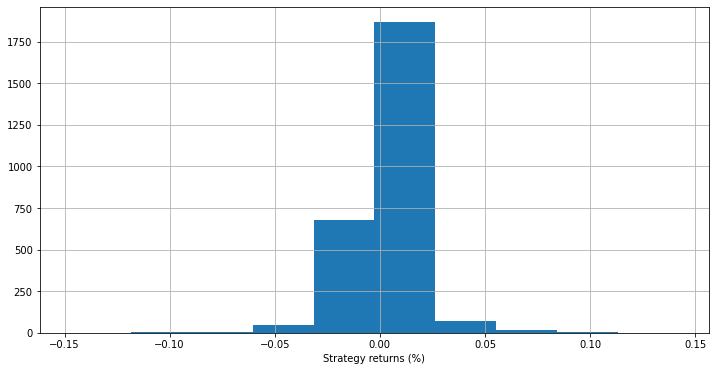

In [138]:
import matplotlib.pyplot as plt
data.strategy_returns[split:].hist()
plt.xlabel('Strategy returns (%)')
plt.show()

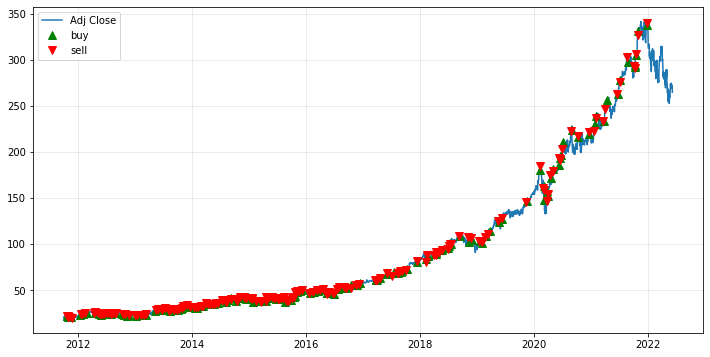

In [139]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(data.iloc[split:]['Adj Close'], label = 'Adj Close')
plt.plot(data[split:].loc[data.entry == 1].index, data[split:]['Adj Close'][data.entry == 1], '^', color = 'g', markersize = 8,label='buy')
plt.plot(data[split:].loc[data.entry == -1].index, data[split:]['Adj Close'][data.entry == -1], 'v',color = 'r', markersize = 8,label='sell')
plt.legend()

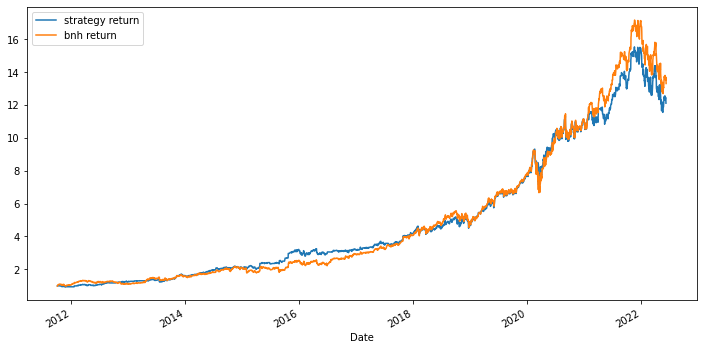

In [141]:
(data.strategy_returns[split:]+1).cumprod().plot(label='strategy return')
(data['return'][split:]+1).cumprod().plot(label='bnh return')
plt.legend()

Start date,1986-11-14
End date,2022-06-09
Total months,426
,Backtest
Annual return,22.4%
Cumulative returns,133486.0%
Annual volatility,26.8%
Sharpe ratio,0.89
Calmar ratio,0.49
Stability,0.90
Max drawdown,-45.8%


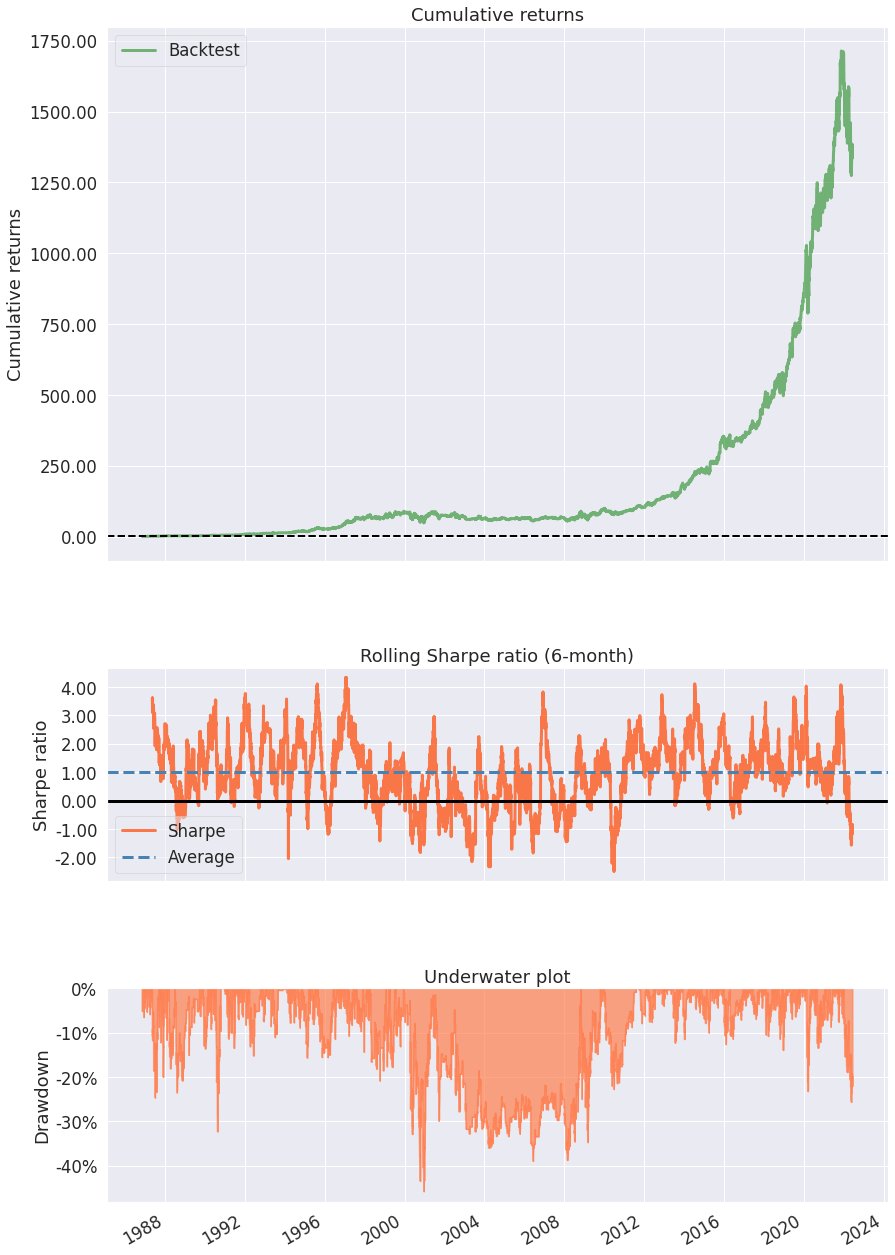

In [143]:
pf.create_simple_tear_sheet(data.strategy_returns)